In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import sys
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from typing import Dict, List, Tuple
from torch.utils.data import DataLoader

notebook_path = "/home/yas50454/repos/STTFormer/tafar-experimental_david-datasets/datasets/preprocess/ntu_preprocess_pytorch.py"
# Add parent directory to path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(notebook_path), '..', '..', '..')))

from ntu_dataset import NTUDataset
import preprocess.augmentations as augmentations
from preprocess.augmentations import Normalize3D
from base_dataset import BaseDataset
from model.sttformer import Model


In [22]:
action_classes = [
    'drink water', 'eat meal/snack', 'brushing teeth', 'brushing hair', 'drop', 'pickup', 'throw', 'sitting down',
    'standing up (from sitting position)', 'clapping', 'reading', 'writing', 'tear up paper', 'wear jacket',
    'take off jacket', 'wear a shoe', 'take off a shoe', 'wear on glasses', 'take off glasses', 'put on a hat/cap',
    'take off a hat/cap', 'cheer up', 'hand waving', 'kicking something', 'reach into pocket', 'hopping (one foot jumping)',
    'jump up', 'make a phone call/answer phone', 'playing with phone/tablet', 'typing on a keyboard',
    'pointing to something with finger', 'taking a selfie', 'check time (from watch)', 'rub two hands together',
    'nod head/bow', 'shake head', 'wipe face', 'salute', 'put palms together', 'cross hands in front',
    'sneeze/cough', 'staggering', 'falling', 'touch head (headache)', 'touch chest (stomachache/heart pain)',
    'touch back (backache)', 'touch neck (neckache)', 'nausea or vomiting condition', 'use a fan (with hand or paper)/feeling warm',
    'punching/slapping other person', 'kicking other person', 'pushing other person', 'pat on back of other person',
    'point finger at the other person', 'hugging other person', 'giving something to other person', 'touch other person\'s pocket',
    'handshaking', 'walking towards each other', 'walking apart from each other'
]

idx_to_class = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
    23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
    44, 45, 46, 47, 48, 49, 50,  51, 52, 53, 54, 55, 56, 57, 58, 59, 60
]

ntu_pairs = [(0, 1), (1, 20), (2, 20), (3, 2), (4, 20), (5, 4),
        (6, 5), (7, 6), (8, 20), (9, 8), (10, 9), (11, 10),
        (12, 0), (13, 12), (14, 13), (15, 14), (16, 0), (17, 16),
        (18, 17), (19, 18), (21, 22), (20, 20), (22, 7), (23, 24), (24, 11)]


In [23]:
output_device = 4 # GPU device

config = [[64,  64,  16], [64,  64,  16], 
           [64,  128, 32], [128, 128, 32],
           [128, 256, 64], [256, 256, 64], 
           [256, 256, 64], [256, 256, 64]]

sttformer_model = Model(len_parts=6,
              num_frames=120,
              num_joints=25,
              num_classes=60,
              num_heads=3,
              num_channels=3,
              num_persons=2,
              kernel_size=[3,5],
              use_pes=True,
              config=config).cuda(output_device)

sttformer_model = nn.DataParallel(sttformer_model, device_ids=[4,5])

In [123]:
class NTU2Feeder:
    """
    Class for preprocessing NTU Dataset as STTFormer feeder format
    """
    def feeder_tensor_reshape(self, tensor: torch.Tensor):
        # tmp_padded = add_padding(tensor, 75) ## ERROR not working well
        # tensor = tensor.unsqueeze(0)
        tmp_reshaped = tensor.permute(3,1,2,0)
        return tmp_reshaped
    
    @staticmethod
    def plot_tensor_skeleton(tensor: torch.Tensor, set_frame: int=None, all_subjects: bool=False):
        """
        Take as input a tensor of shape (C, T, V, M)
        """
        ntu_pairs = [(0, 1), (1, 20), (2, 20), (3, 2), (4, 20), (5, 4),
                (6, 5), (7, 6), (8, 20), (9, 8), (10, 9), (11, 10),
                (12, 0), (13, 12), (14, 13), (15, 14), (16, 0), (17, 16),
                (18, 17), (19, 18), (21, 22), (20, 20), (22, 7), (23, 24), (24, 11)]
        print(tensor.shape)
        
        if set_frame is not None:
            if set_frame > tensor.shape[1]:
                raise ValueError(f"Frame value to high, total frame {tensor.shape[1]}")
            else:
                random_frame_idx = set_frame
        else:
            random_frame_idx = random.choice(range(tensor.shape[1]))

        tensor_reshaped = tensor.permute(3, 1, 2, 0)

        if all_subjects:
            x_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,0] 
            y_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,1]

            x_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,0] 
            y_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,1]

            plt.figure(figsize=(4,6))
            for i,j in ntu_pairs:
                plt.plot([x_keypoint_0[i], x_keypoint_0[j]], [y_keypoint_0[i],y_keypoint_0[j]], c='b', marker='o')
                plt.plot([x_keypoint_1[i], x_keypoint_1[j]], [y_keypoint_1[i],y_keypoint_1[j]], c='r', marker='o')
            
            plt.xlim([np.amin(tensor_reshaped[:,:,:,0].numpy()), np.amax(tensor_reshaped[:,:,:,0].numpy())])
            plt.ylim([np.amin(tensor_reshaped[:,:,:,1].numpy()), np.amax(tensor_reshaped[:,:,:,1].numpy())])

            title = f"Sample total lengh: {tensor_reshaped.shape[1]} frame: {random_frame_idx}"
            plt.title(title)
        else:
            x_keypoint = tensor_reshaped[0][random_frame_idx][:,0] 
            y_keypoint = tensor_reshaped[0][random_frame_idx][:,1]
            plt.figure(figsize=(4,6))
            for i,j in ntu_pairs:
                plt.plot([x_keypoint[i], x_keypoint[j]], [y_keypoint[i],y_keypoint[j]], c='b', marker='o')
            
            plt.xlim([np.amin(tensor_reshaped[0,:,:,0].numpy()), np.amax(tensor_reshaped[0,:,:,0].numpy())])
            plt.ylim([np.amin(tensor_reshaped[0,:,:,1].numpy()), np.amax(tensor_reshaped[0,:,:,1].numpy())])

            title = f"Sample total lengh: {tensor_reshaped.shape[1]} frame: {random_frame_idx}"
            plt.title(title)
            
    def crop_frames(self, tensor: torch.Tensor, window_size):
        C, T, V, M = tensor.shape
        if M == 2:
            if T < window_size:
                # If the window size is longer than the actual frame length,
                # we pad the tensor with zeros along the T dimension
                padded_tensor = torch.zeros((C, window_size, V, M))
                padded_tensor[:, :T, :, :] = tensor
                return padded_tensor
            
            # If the crop size is shorter, we don't need to pad the tensor
            tensor_permuted = tensor.permute(3,2,0,1)
            tensor_cropped = tensor_permuted[:,:,:,:window_size]
            M, V, C, T = tensor_cropped.shape
            cropped_tensor = tensor_cropped.permute(2,3,1,0)
            return cropped_tensor
        if T < window_size:
            # If the window size is longer than the actual frame length,
            # we pad the tensor with zeros along the T dimension
            padded_tensor = torch.zeros((C, window_size, V, M))
            padded_tensor[:, :T, :, :] = tensor
            padded_tensor = padded_tensor.permute(3,1,2,0)
            padded_tensor_added = torch.zeros((2, window_size, V, C))
            padded_tensor_added[:1,:,:,:] = padded_tensor
            padded_tensor_added = padded_tensor_added.permute(3,1,2,0)
            return padded_tensor_added
        
        tensor_permuted = tensor.permute(3,2,0,1)
        tensor_cropped = tensor_permuted[:,:,:,:window_size]
        padded_tensor = tensor_cropped.permute(0,3,1,2)
        M, T, V, C = padded_tensor.shape
        padded_tensor_added = torch.zeros((2, T, V, C))
        padded_tensor_added[:1,:,:,:] = padded_tensor
        padded_tensor_added = padded_tensor_added.permute(3,1,2,0)
        return padded_tensor_added
    
    def __init__(self, window_size: int=120):
        self.window_size = window_size

    def __call__(self, dataset_item):
        skeleton = dataset_item['keypoint']
        tensor = torch.tensor(skeleton)
        tensor = self.feeder_tensor_reshape(tensor)
        tensor_cropped = self.crop_frames(tensor, self.window_size)
        dataset_item['keypoint'] = tensor_cropped.numpy()
        dataset_item['input'] = tensor_cropped.numpy() #copy keypoint content to input (to solve problem of shape for Dataloader)

        return dataset_item
                

In [25]:
ann_file = '/home/yas50454/datasets/NTU_Data/NTU_60/ntu60_3danno.pkl'
ntu2feeder = NTU2Feeder(window_size=120)
pipeline = torchvision.transforms.Compose([ntu2feeder])
ntu_feeder_train_dataset = NTUDataset(ann_file, pipeline=pipeline, split='xsub_train', num_classes=60, multi_class=True, augmentation=None)

In [26]:
ntu2feeder = NTU2Feeder(window_size=120)
pipeline = torchvision.transforms.Compose([ntu2feeder])
ntu_feeder_test_dataset = NTUDataset(ann_file, pipeline=pipeline, split='xsub_val', num_classes=60, multi_class=True, augmentation=None)

In [27]:
from torchinfo import summary
summary(sttformer_model, input_size=[64, 3, 120, 25, 2])

Layer (type:depth-idx)                        Output Shape              Param #
DataParallel                                  [64, 60]                  --
├─Model: 1-1                                  [32, 60]                  6,233,588
├─Model: 1-4                                  --                        (recursive)
│    └─Sequential: 2-1                        [64, 64, 20, 150]         384
│    └─Sequential: 2-8                        --                        (recursive)
│    │    └─Conv2d: 3-1                       [64, 64, 20, 150]         256
├─Model: 1-3                                  [32, 60]                  --
├─Model: 1-4                                  --                        (recursive)
│    └─Sequential: 2-8                        --                        (recursive)
│    │    └─BatchNorm2d: 3-2                  [64, 64, 20, 150]         128
│    │    └─LeakyReLU: 3-3                    [64, 64, 20, 150]         --
│    └─ModuleList: 2-14                       -- 

In [28]:
### Training step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=output_device):
    train_loss, train_acc = 0, 0

    model.train()
    
    for batch, batch_item in enumerate(dataloader):
        X = batch_item['keypoint']
        y = batch_item['label']
        with torch.no_grad():
            X = X.float().cuda(output_device)
            y = y.float().cuda(output_device)
        
        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=0), dim=1)
        y_argmax = torch.argmax(y, dim=1)
        train_acc += (y_pred_class==y_argmax).sum().item()/len(y_pred)
    
    # Adjust metrics to get average los and accuracy 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc        

In [29]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=output_device):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, batch_item in enumerate(dataloader):
            X = batch_item['keypoint']
            y = batch_item['label']
            X, y = X.float().cuda(output_device), y.float().cuda(output_device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=0), dim=1)
            y_argmax = torch.argmax(y, dim=1)
            test_acc += (y_pred_class==y_argmax).sum().item()/len(y_pred)
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [30]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=output_device):
    
    results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}, lr: {learning_rate} ")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [31]:
ntu_train_dataloader = DataLoader(dataset=ntu_feeder_train_dataset,
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               num_workers=os.cpu_count())

In [32]:
ntu_test_dataloader = DataLoader(dataset=ntu_feeder_test_dataset,
                               batch_size=64,
                               shuffle=False,
                               drop_last=True,
                               num_workers=os.cpu_count())

In [33]:
learning_rate = 0.1
weight_decay = 0.0004
loss_fn = nn.CrossEntropyLoss().cuda(output_device)
optimizer = optim.SGD(sttformer_model.parameters(),
                      lr=learning_rate,
                      momentum=0.9,
                      nesterov=True,
                      weight_decay=weight_decay)

In [34]:
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_epochs = 6

start_time = timer()

# Train model_0
model_0_results = train(model=sttformer_model,
                        train_dataloader=ntu_train_dataloader,
                        test_dataloader=ntu_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=num_epochs,
                        device=output_device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 3.2109 | Train acc: 0.1633 | Test loss: 3.9798 | Test acc: 0.1310, lr: 0.1 
Epoch: 1 | Train loss: 1.6747 | Train acc: 0.4924 | Test loss: 2.2467 | Test acc: 0.4061, lr: 0.1 
Epoch: 2 | Train loss: 1.2490 | Train acc: 0.6117 | Test loss: 1.5284 | Test acc: 0.5421, lr: 0.1 
Epoch: 3 | Train loss: 1.1141 | Train acc: 0.6505 | Test loss: 1.4395 | Test acc: 0.5784, lr: 0.1 
Epoch: 4 | Train loss: 1.0298 | Train acc: 0.6751 | Test loss: 1.4935 | Test acc: 0.5626, lr: 0.1 
Epoch: 5 | Train loss: 0.9676 | Train acc: 0.6921 | Test loss: 1.2961 | Test acc: 0.6176, lr: 0.1 
Total training time: 5685.501 seconds


In [35]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training curves of a results doctionary.
  """
  # Get the loss valurs of the results dict
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs,loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

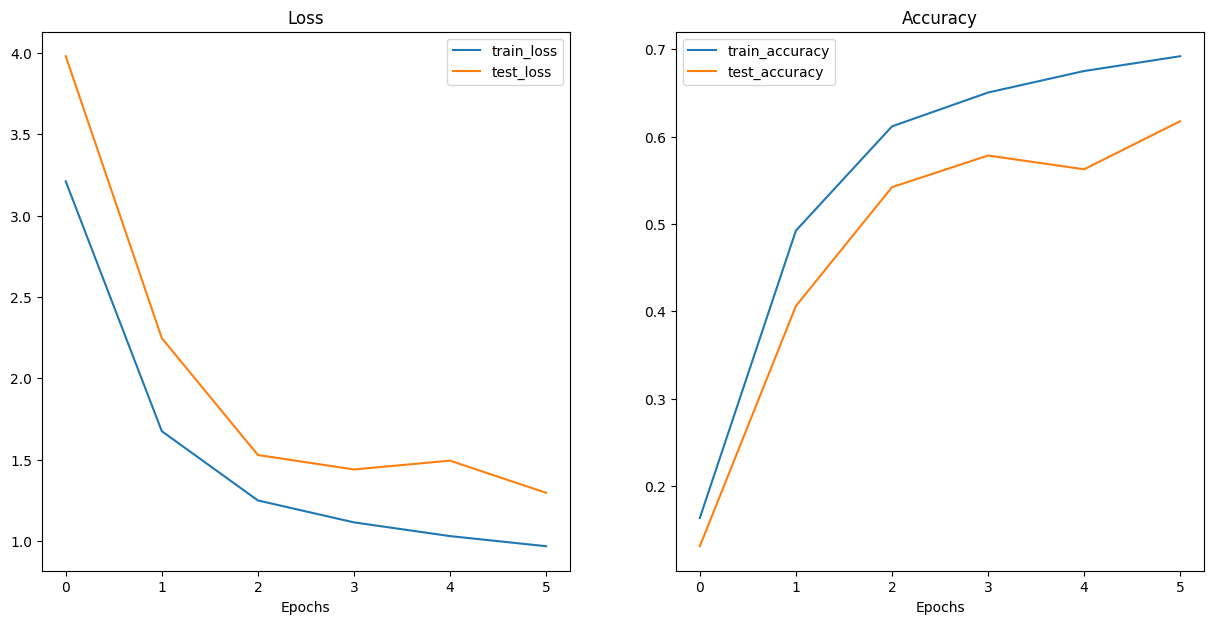

In [36]:
plot_loss_curves(model_0_results)

In [39]:
def make_predictions(model: torch.nn.Module,
                    data: List[torch.Tensor],
                    device: int):
    pred_probs = []
    model.cuda(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = sample.unsqueeze(0).cuda(device)
            pred = model(sample)
            pred_prob = torch.softmax(pred.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    
    return torch.stack(pred_probs)

In [52]:
# random.seed(42)
test_samples = []
test_labels = []

for sample in random.sample(list(ntu_feeder_test_dataset), k=9):
    _, sample_label, sample_keypoint, _, _, _ = sample.values()
    test_samples.append(sample_keypoint)
    test_labels.append(sample_label)

test_samples[0].shape

torch.Size([3, 120, 25, 2])

torch.Size([3, 120, 25, 2])


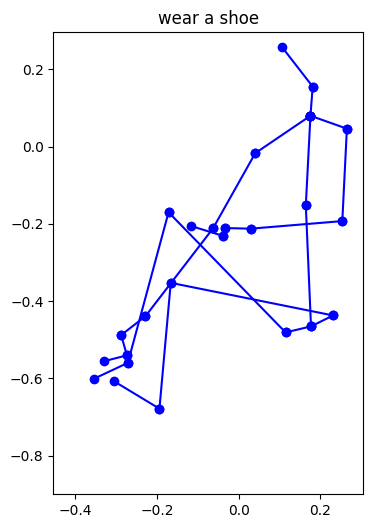

In [124]:
NTU2Feeder.plot_tensor_skeleton(test_samples[0], set_frame=50)
plt.title(action_classes[torch.argmax(test_labels[0])]);

In [83]:
pred_probs = make_predictions(model=sttformer_model,
                            data= test_samples, device=output_device)
pred_classes = list(pred_probs.argmax(dim=1).numpy())
pred_classes

[15, 19, 35, 35, 47, 26, 29, 1, 41]

In [82]:
test_labels_int = [int(i.argmax(dim=0).numpy()) for i in test_labels] 
test_labels_int

[15, 19, 35, 35, 47, 26, 11, 1, 41]

In [121]:
# Plot results
def plot_predictions(test_samples,
                    pred_classes,
                    test_labels,
                    all_subjects=False):
    plt.figure(figsize=(10,10))
    nrows, ncols = 3, 3
    for i, sample in enumerate(test_samples):
        plt.subplot(nrows, ncols, i+1)
        ntu_pairs = [(0, 1), (1, 20), (2, 20), (3, 2), (4, 20), (5, 4),
                    (6, 5), (7, 6), (8, 20), (9, 8), (10, 9), (11, 10),
                    (12, 0), (13, 12), (14, 13), (15, 14), (16, 0), (17, 16),
                    (18, 17), (19, 18), (21, 22), (20, 20), (22, 7), (23, 24), (24, 11)]
        
        random_frame_idx = random.choice(range(50))

        tensor_reshaped = sample.permute(3, 1, 2, 0)
        pred_label = action_classes[pred_classes[i]]
        truth_label = action_classes[test_labels_int[i]]

        title_text = f"Pred: {pred_label} \n Truth: {truth_label}"
        title_text += f"\nSample total lengh: {tensor_reshaped.shape[1]} frame: {random_frame_idx}"
        if pred_label == truth_label:
            plt.title(title_text, fontsize=8, c='g')
        else:
            plt.title(title_text, fontsize=8, c='r')

        if all_subjects:
            x_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,0] 
            y_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,1]

            x_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,0] 
            y_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,1]

            for i,j in ntu_pairs:
                plt.plot([x_keypoint_0[i], x_keypoint_0[j]], [y_keypoint_0[i],y_keypoint_0[j]], c='b', marker='o')
                plt.plot([x_keypoint_1[i], x_keypoint_1[j]], [y_keypoint_1[i],y_keypoint_1[j]], c='r', marker='o')
            
            plt.xlim([np.amin(tensor_reshaped[:,:,:,0].numpy()), np.amax(tensor_reshaped[:,:,:,0].numpy())])
            plt.ylim([np.amin(tensor_reshaped[:,:,:,1].numpy()), np.amax(tensor_reshaped[:,:,:,1].numpy())])
            plt.axis(True)
        else:
            x_keypoint = tensor_reshaped[0][random_frame_idx][:,0] 
            y_keypoint = tensor_reshaped[0][random_frame_idx][:,1]
            for i,j in ntu_pairs:
                plt.plot([x_keypoint[i], x_keypoint[j]], [y_keypoint[i],y_keypoint[j]], c='b', marker='o')
            
            plt.xlim([np.amin(tensor_reshaped[0,:,:,0].numpy()), np.amax(tensor_reshaped[0,:,:,0].numpy())])
            plt.ylim([np.amin(tensor_reshaped[0,:,:,1].numpy()), np.amax(tensor_reshaped[0,:,:,1].numpy())])
            plt.axis(True)
    plt.subplots_adjust(hspace=0.35)

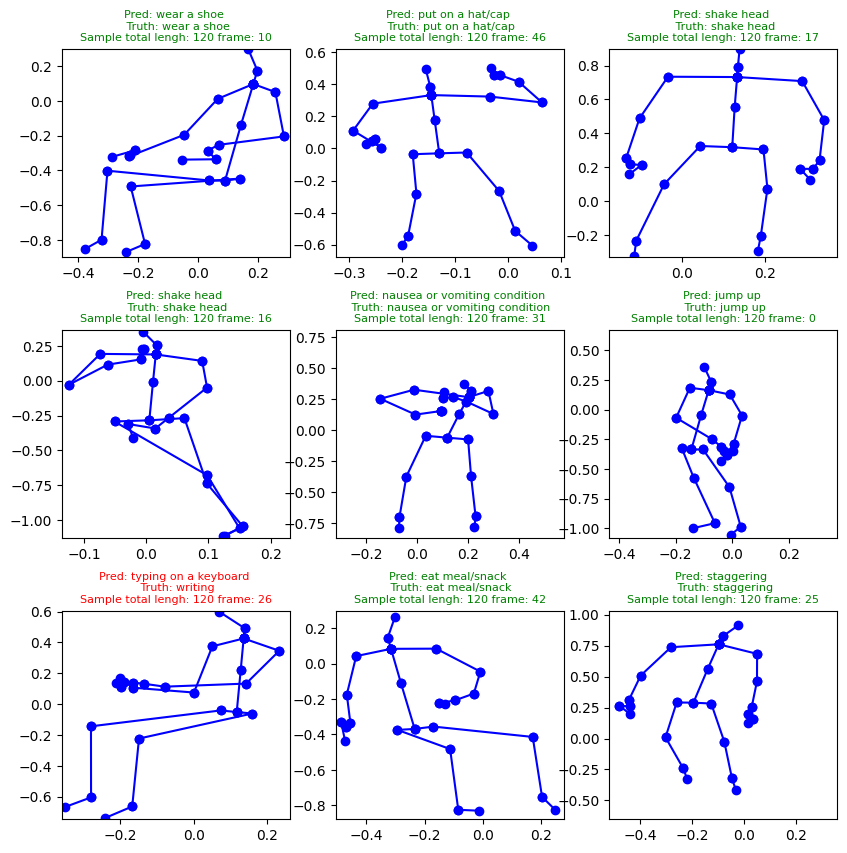

In [122]:
plot_predictions(test_samples=test_samples,
                pred_classes=pred_classes,
                test_labels=test_labels,
                all_subjects=False)

In [125]:
y_pred_test = sttformer_model(next(iter(ntu_test_dataloader))['keypoint'])

In [136]:
y_preds = []
sttformer_model.eval()
with torch.inference_mode():
    for batch, batch_item in enumerate(ntu_test_dataloader):
        X = batch_item['keypoint']
        y = batch_item['label']
        X, y = X.float().cuda(output_device), y.float().cuda(output_device)

        y_pred = sttformer_model(X)

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=0), dim=1)
        y_preds.append(y_pred_class.cpu())

# Concat list of preds into tensor
y_pred_tensor = torch.cat(y_preds)
print(y_pred_tensor)

tensor([ 0,  1,  2,  ..., 18, 19, 20])


In [141]:
y_pred_tensor.shape

torch.Size([16448])

In [140]:
ntu_test_labels = torch.tensor([item['label'].argmax(dim=0) for item in ntu_feeder_test_dataset])

In [145]:
ntu_test_labels = ntu_test_labels[:y_pred_tensor.shape[0]]
ntu_test_labels[:70]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [150]:
# Confusion matrix
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(action_classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=ntu_test_labels)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=action_classes,
                                figsize=(16,12))


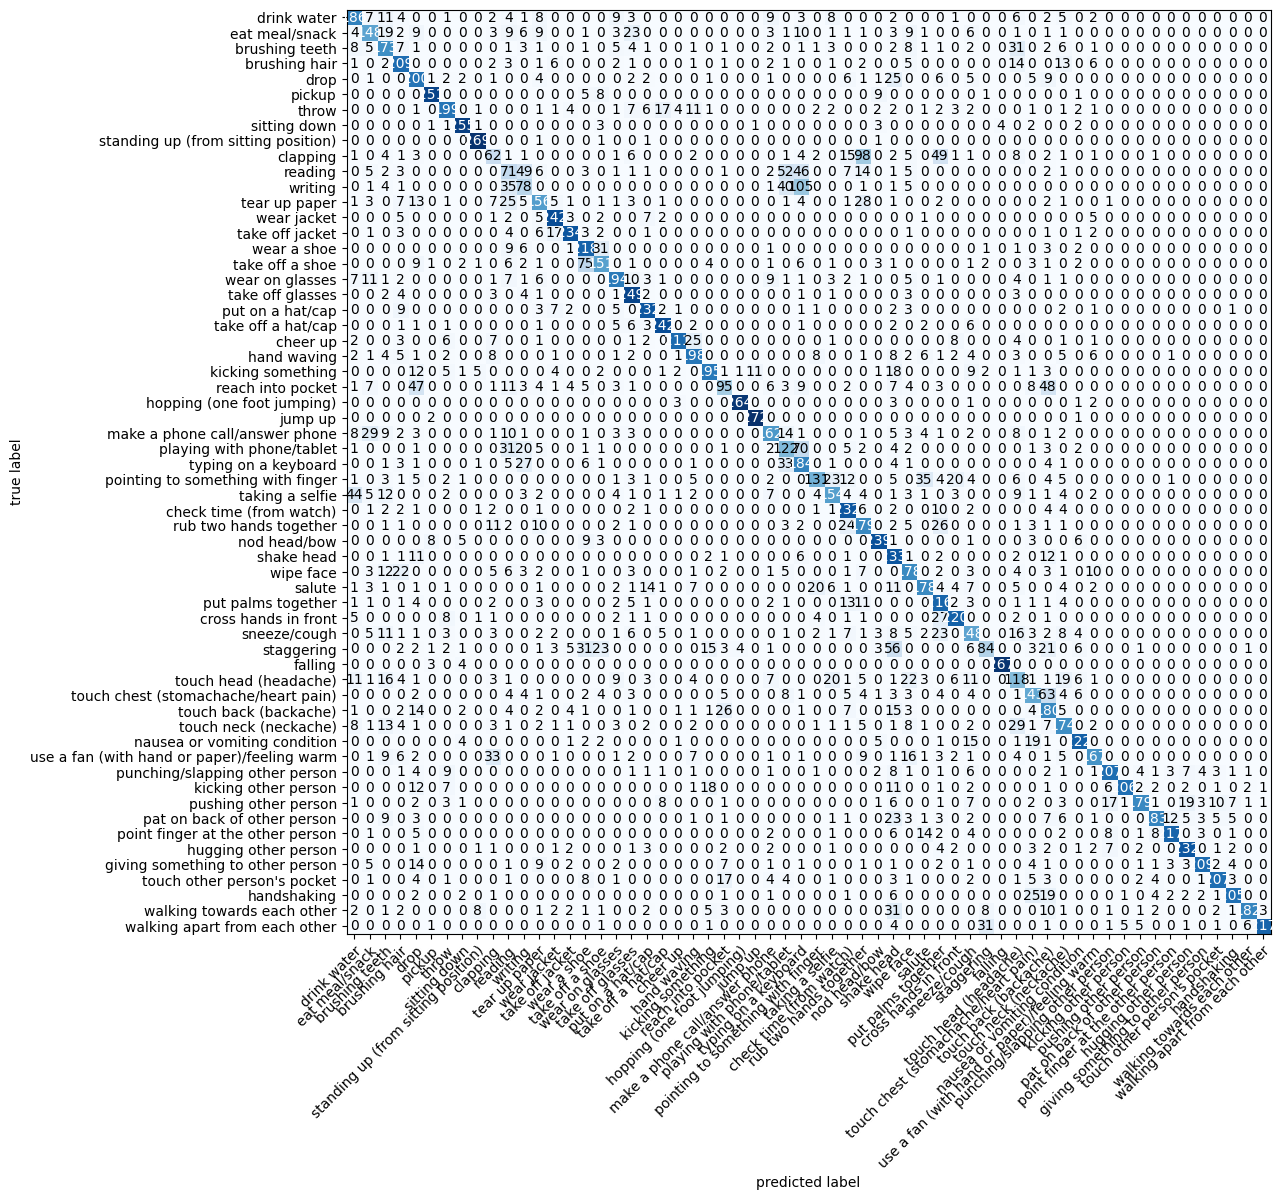

In [153]:
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=action_classes,
                                figsize=(20,12))

In [37]:
from pathlib import Path
import datetime

# Create model dir path
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

# Create model save
timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
model_name = f"sttformer_{timestamp}.pth"
model_save_path = model_path/model_name

#save model state dict
print(f"Saving model to:{model_save_path}")
torch.save(obj=sttformer_model.state_dict(), f=model_save_path)

Saving model to:models/sttformer_2023_05_09_18_42_24.pth


In [38]:
# Create new model instance
torch.manual_seed(42)

output_device = 4 # GPU device

config = [[64,  64,  16], [64,  64,  16], 
           [64,  128, 32], [128, 128, 32],
           [128, 256, 64], [256, 256, 64], 
           [256, 256, 64], [256, 256, 64]]

load_sttforemer_model = Model(len_parts=6,
              num_frames=120,
              num_joints=25,
              num_classes=60,
              num_heads=3,
              num_channels=3,
              num_persons=2,
              kernel_size=[3,5],
              use_pes=True,
              config=config).cuda(output_device)
load_sttforemer_model = nn.DataParallel(load_sttforemer_model, device_ids=[4,5])

# Load saved state_dict
load_sttforemer_model.load_state_dict(torch.load(f=model_save_path))
load_sttforemer_model


DataParallel(
  (module): Model(
    (input_map): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (blocks): ModuleList(
      (0): STA_Block(
        (pes): Pos_Embed()
        (to_qkvs): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
        (out_nets): Sequential(
          (0): Conv2d(192, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (ff_net): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (out_nett): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T